In [4]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0 --ignore-installed

  Using cached https://files.pythonhosted.org/packages/cf/a2/b754273c8d9650011712cd5542d179feccfb69ceb492d23f61ab190bada4/tensorflow-2.0.0b0-cp37-cp37m-macosx_10_11_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d0/33/376510eb8d6246f3c30545f416b2263eee461e40940c2a4413c711bdf62d/google_pasta-0.1.7-py3-none-any.whl
    100% |████████████████████████████████| 15.0MB 1.1MB/s ta 0:00:01
    100% |████████████████████████████████| 2.0MB 3.7MB/s ta 0:00:011
    100% |████████████████████████████████| 1.4MB 4.7MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/a4/96/571b875cd81dda9d5dfa1422a4f9d749e67c0a8d4f4f0b33a4e5f5f35e27/tb_nightly-1.14.0

### Import necessary modules:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from functools import reduce
import os
import json
from PIL import Image

### Get a list of all hashtags

In [ ]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [9]:
# remove '.DS_', '.ipynb_checkp'
hashtags.remove('.DS_')
hashtags.remove('.ipynb_checkp')
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [10]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [11]:
full_list = pd.DataFrame.reset_index(df, drop=True)

In [14]:
full_list.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,"[#Wedding, #ido, #ianandwendytietheknot, #wedd...",https://scontent-sea1-1.cdninstagram.com/vp/29...,905a1d9c-b29d-44c7-ab5c-408c0b5d91ac.jpg,https://www.instagram.com/p/B0dcq0FBPQ3/,wedding
2996,"[#wedding, #mariages, #celebrantecuritiba, #ce...",https://scontent-sea1-1.cdninstagram.com/vp/bb...,6e424f02-d10e-42db-a233-9ce2724fb8a9.jpg,https://www.instagram.com/p/BwXbu7MgCTZ/,wedding
2997,"[#weddingring, #wedding, #shoes, #nancy, #sigm...",https://scontent-sea1-1.cdninstagram.com/vp/25...,ae49d2bb-95f7-4d16-9ee5-1603e97e6dd8.jpg,https://www.instagram.com/p/B0gwuc2icKv/,wedding
2998,"[#wedding, #standesamtgoetheallee, #retroweddi...",https://scontent-sea1-1.cdninstagram.com/vp/21...,9152a6d4-abda-4adf-87a4-7988dc4bb3ac.jpg,https://www.instagram.com/p/B0gwufzImAz/,wedding
2999,"[#kinalik, #gelinlik, #bursad, #wedding, #dama...",https://scontent-sea1-1.cdninstagram.com/vp/15...,09aaa471-2ed6-4ead-84db-e4aa6b0ece8f.jpg,https://www.instagram.com/p/B0gwubDhu6M/,wedding


### Resizing image to be used in tensorflow framework for Deep Feature Extraction

In [15]:
img_size = 160 # All images will be resized to 160x160
img_shape = (160, 160, 3)

def prepare_image(img_path, height=img_size, width=img_size):
    """Downsample and scale image to prepare it for neural network"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (height, width))
    # Reshape B&W images to match dimensions of color images
    if img.shape != (160, 160, 3):
        img = tf.concat([img, img, img], axis=2)
    return img

In [16]:
pics = []
for i, row in full_list.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path)
        pics.append({'pic': img, 'hashtag': hashtag, 'name': name})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [17]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0808 08:58:21.336809 4527449536 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


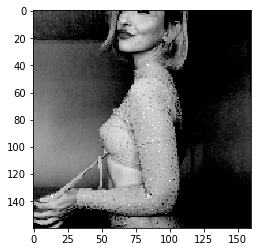

In [18]:
plt.imshow(pics[64]['pic']);

In [19]:
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [20]:
def extract_features(image_dict):
    """Return a vector of 1280 deep features for image."""
    image = image_dict['pic']
    image_np = image.numpy()
    images_np = np.expand_dims(image_np, axis=0)
    image_np.shape, images_np.shape
    deep_features = neural_network.predict(images_np)
    image_dict['deep_features'] = deep_features[0]
    return image_dict

In [21]:
deep_features = list(map(extract_features, pics))

In [22]:
type(deep_features)

list

In [23]:
shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [24]:
train[0]

{'pic': <tf.Tensor: id=70907, shape=(160, 160, 3), dtype=float32, numpy=
 array([[[-0.44509804, -0.26470584, -0.21764702],
         [ 0.03921568,  0.227451  ,  0.27058828],
         [-0.80588233, -0.59803927, -0.5627451 ],
         ...,
         [ 0.6392157 ,  0.8509804 ,  1.        ],
         [ 0.62352943,  0.8509804 ,  0.99215686],
         [ 0.6156863 ,  0.8509804 ,  0.99215686]],
 
        [[-0.76274514, -0.6       , -0.5470588 ],
         [-0.7980392 , -0.62352943, -0.5745098 ],
         [-0.82941175, -0.63725495, -0.59607846],
         ...,
         [ 0.6392157 ,  0.8509804 ,  1.        ],
         [ 0.62352943,  0.8509804 ,  0.99215686],
         [ 0.6156863 ,  0.8509804 ,  0.99215686]],
 
        [[-0.84313726, -0.6960784 , -0.64117646],
         [-0.87058824, -0.7156863 , -0.66078436],
         [-0.84901965, -0.6745098 , -0.6254902 ],
         ...,
         [ 0.6392157 ,  0.8509804 ,  1.        ],
         [ 0.6313726 ,  0.85882354,  1.        ],
         [ 0.62352943,  0.858

In [25]:
train[0].keys()

dict_keys(['pic', 'hashtag', 'name', 'deep_features'])

In [26]:
pic = train[0]

W0808 09:02:33.113436 4527449536 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


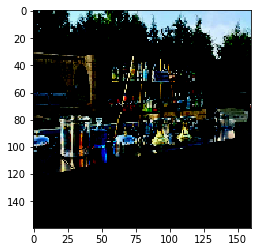

In [27]:
plt.imshow(pic['pic']);

In [28]:
pic['hashtag']

'wedding'

In [29]:
pic['deep_features'].shape

(1280,)

In [30]:
pic['pic'].shape

TensorShape([160, 160, 3])

In [31]:
df = pd.DataFrame(deep_features)

In [32]:
df.head()

,deep_features,hashtag,name,pic
0,"[0.0, 0.0, 0.0, 0.9403897, 0.013560877, 0.5415...",wedding,cc4ddfb1-9d3b-4429-8736-f4aa4b553abb.jpg,"(((tf.Tensor(-0.44509804, shape=(), dtype=floa..."
1,"[1.2038865, 0.1280765, 0.0, 0.08866347, 0.5180...",babies,47a70842-b5d3-4246-a823-d3b979615e79.jpg,"(((tf.Tensor(0.99215686, shape=(), dtype=float..."
2,"[0.0, 0.14218274, 0.29680854, 0.46161124, 0.10...",architecture,0b51899b-dc3c-4f30-9230-3f5223cf79a6.jpg,"(((tf.Tensor(0.52156866, shape=(), dtype=float..."
3,"[0.049770802, 0.40196633, 0.6088646, 0.5214633...",selfie,b861224a-3e23-4726-a786-0dfbdafba3c0.jpg,"(((tf.Tensor(0.6039216, shape=(), dtype=float3..."
4,"[0.7323788, 0.014615268, 0.22212349, 0.6641924...",babies,4c537c13-1249-4aa1-9e03-9615b3deeeef.jpg,"(((tf.Tensor(-0.16274509, shape=(), dtype=floa..."


In [33]:
df.to_pickle("df_deep_features.pkl")

In [34]:
#df.to_csv('deep_features.csv')

## ALS Model

In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel

In [36]:
spark = SparkSession.builder.master('local').getOrCreate()

In [37]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_list, test_size=0.2)

In [38]:
train.head()

,hashtags,image,image_local_name,post_link,search_hashtag
2636,"[#adorable, #love, #photooftheday, #dogsofinst...",https://scontent-lga3-1.cdninstagram.com/vp/ff...,b25ab7a3-897b-4b80-9501-55e148896c9b.jpg,https://www.instagram.com/p/By3n8U2FPej/,animals
1827,"[#cookingforfriendsandfamily, #montreal, #home...",https://scontent-lga3-1.cdninstagram.com/vp/7b...,a889b6ef-3738-45b8-a137-db6a43b28540.jpg,https://www.instagram.com/p/By3eJDpHtgX/,food
2190,[architecture],NaN,d0fe96d9-5eee-48af-bee6-66ae37dde44d.jpg,NaN,architecture
1559,"[#ft, #fastandfurious, #carmeet, #brz, #scion,...",https://scontent-sea1-1.cdninstagram.com/vp/26...,5684a5f7-b849-4cf8-98a9-84514574e3d2.jpg,https://www.instagram.com/p/B0hQtJsHCMK/,cars
1579,"[#mercedes, #followme, #likes, #instagood, #ta...",https://scontent-sea1-1.cdninstagram.com/vp/0a...,ecc8ab1f-4dcf-4d44-bce4-6cde965b66d2.jpg,https://www.instagram.com/p/B0hQrCIp9Vg/,cars


In [39]:
len(train)

2400

In [40]:
#full_list.head()

In [41]:
full_list['clean_hashtags'] = full_list['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

In [42]:
image_lookup = dict(zip(full_list['image_local_name'], full_list.index))

In [43]:
all_hashtags = set()
for tags in full_list['clean_hashtags']:
    all_hashtags.update(tags)
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [44]:
hashtag_data = []
for i in full_list.index:
    hashtags = full_list.loc[i, 'clean_hashtags']
    for hashtag in hashtags:
        hashtag_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_df_long = pd.DataFrame(hashtag_data)

In [45]:
hashtag_df_long.tail()

,hashtag_id,image_id,rating
41500,7458,2999,1
41501,9695,2999,1
41502,11355,2999,1
41503,1723,2999,1
41504,1269,2999,1


In [46]:
full_list.dtypes

hashtags            object
image               object
image_local_name    object
post_link           object
search_hashtag      object
clean_hashtags      object
dtype: object

In [47]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

In [48]:
hashtag_spark_df = spark.createDataFrame(hashtag_df_long)

In [49]:
als_model = als.fit(hashtag_spark_df)

In [51]:
als_model.save('als_model')

In [52]:
#load the model
#ALSModel model = ALSModel.load(“/path/to/read/the/model/from”)

In [53]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()

In [54]:
len(recs)

1973

In [55]:
hashtag_index = list(all_hashtags)

In [56]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

In [57]:
def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [58]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [59]:
recs.index = recs['image_id']

In [60]:
compare_recs = recs.join(full_list, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [61]:
compare_recs.loc[0, 'image_local_name']

'ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg'

In [62]:
compare_recs.to_pickle('recs.pkl')

In [63]:
compare_recs.drop('recommendations', axis=1)

,recommended_hashtags,hashtags,image_local_name,search_hashtag
image_id,,,,
1580,"[#luxury, #car, #cars, #love, #carsofinstagram...","[#checkeredflag, #atv, #flagmanracing, #dirtbi...",88039d35-d189-4db3-926e-a120d88a3efc.jpg,cars
471,"[#selfie, #beauty, #ootd, #fashion, #girl, #su...","[#followme, #fashiondaily, #summer, #food, #ma...",fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,selfie
1591,"[#cars, #car, #luxury, #trucks, #carsofinstagr...","[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...",1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,cars
463,"[#selfie, #wedding, #photographer, #fashion, #...","[#followme, #hotguy, #instaboy, #gay, #instaga...",a78d0e30-6afa-436a-a953-633ef3f64325.jpg,selfie
833,"[#sunset, #cars, #travel, #sun, #photography, ...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel
1645,"[#cars, #car, #photo, #fiat, #fiatvivace, #enc...","[#cl, #fiat, #sangreitaliana, #mi, #sorpasso, ...",1b2b963b-6c4d-4c79-b88d-b04f34104a1c.jpg,cars
496,"[#selfie, #f, #l, #follow, #like, #followme, #...","[#fashion, #oufit, #likeforlike, #selfie, #l, #f]",97f23d6a-0895-4e47-99de-af849207d71b.jpg,selfie
2866,"[#makeup, #wedding, #makeupartist, #photoshoot...","[#teethwhitening, #temecula, #nailtech, #naili...",aad5291e-ed07-4a9a-8525-d8b1fe1bb493.jpg,wedding
148,"[#food, #fitness, #foodie, #instafood, #health...","[#pyszne, #dietetyczny, #motywacja, #healthyfo...",79b4e782-1b3f-4ecd-b0d3-9ea54cf4d037.jpg,fitness


In [64]:
image_factors = als_model.userFactors.toPandas()

In [65]:
image_factors.index = image_factors['id']

In [66]:
compare_recs.join(image_factors)

,recommendations,recommended_hashtags,hashtags,image_local_name,search_hashtag,id,features
image_id,,,,,,,
1580,"[(11726, 1.2205473184585571), (7638, 1.0976204...","[#luxury, #car, #cars, #love, #carsofinstagram...","[#checkeredflag, #atv, #flagmanracing, #dirtbi...",88039d35-d189-4db3-926e-a120d88a3efc.jpg,cars,1580,"[0.9743834137916565, -0.5692329406738281, 0.47..."
471,"[(2399, 1.1536394357681274), (6412, 1.14570438...","[#selfie, #beauty, #ootd, #fashion, #girl, #su...","[#followme, #fashiondaily, #summer, #food, #ma...",fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,selfie,471,"[-0.19726665318012238, -0.14174753427505493, 0..."
1591,"[(8394, 0.9458842277526855), (7638, 0.85855448...","[#cars, #car, #luxury, #trucks, #carsofinstagr...","[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...",1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,cars,1591,"[0.6441309452056885, -0.5491575598716736, 0.55..."
463,"[(2399, 0.8559869527816772), (11988, 0.7232627...","[#selfie, #wedding, #photographer, #fashion, #...","[#followme, #hotguy, #instaboy, #gay, #instaga...",a78d0e30-6afa-436a-a953-633ef3f64325.jpg,selfie,463,"[-0.48255831003189087, -0.1489773690700531, 0...."
833,"[(3723, 0.958864688873291), (8394, 0.948372125...","[#sunset, #cars, #travel, #sun, #photography, ...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel,833,"[-0.03402460366487503, -0.3135524094104767, 0...."
1645,"[(8394, 0.8917215466499329), (7638, 0.85742270...","[#cars, #car, #photo, #fiat, #fiatvivace, #enc...","[#cl, #fiat, #sangreitaliana, #mi, #sorpasso, ...",1b2b963b-6c4d-4c79-b88d-b04f34104a1c.jpg,cars,1645,"[0.11285102367401123, -0.5635216236114502, 0.5..."
496,"[(2399, 0.8866553902626038), (2485, 0.72967314...","[#selfie, #f, #l, #follow, #like, #followme, #...","[#fashion, #oufit, #likeforlike, #selfie, #l, #f]",97f23d6a-0895-4e47-99de-af849207d71b.jpg,selfie,496,"[-0.3612527549266815, 0.06857343018054962, 0.1..."
2866,"[(3385, 0.9868698120117188), (11988, 0.9156723...","[#makeup, #wedding, #makeupartist, #photoshoot...","[#teethwhitening, #temecula, #nailtech, #naili...",aad5291e-ed07-4a9a-8525-d8b1fe1bb493.jpg,wedding,2866,"[0.051123932003974915, 0.2728700339794159, 0.4..."
148,"[(2406, 1.0069363117218018), (1594, 0.92306315...","[#food, #fitness, #foodie, #instafood, #health...","[#pyszne, #dietetyczny, #motywacja, #healthyfo...",79b4e782-1b3f-4ecd-b0d3-9ea54cf4d037.jpg,fitness,148,"[0.4137748181819916, 0.30565571784973145, -0.0..."


### Pickle hashtag data

In [67]:
hashtag_lookup

{'#marche': 0,
 '#culinary': 1,
 '#RestauranteVirtual': 2,
 '#littium': 3,
 '#adventurecat': 4,
 '#bestdeals': 5,
 '#titanicfunkopop': 6,
 '#airportcarpet': 7,
 '#followback': 8,
 '#peugeottina': 9,
 '#dienstag': 10,
 '#saadlamjarred': 11,
 '#citizenecodrive': 12,
 '#doktor': 13,
 '#canberra': 14,
 '#SRT': 15,
 '#polska': 16,
 '#lamborghiniaventador': 17,
 '#summercamp': 18,
 '#objetivos': 19,
 '#fitnessinspiration': 20,
 '#arc': 21,
 '#goodday': 22,
 '#veganlifestyle': 23,
 '#foodtruck': 24,
 '#kater': 25,
 '#pecat': 26,
 '#vegetarian': 27,
 '#blondesandcookies': 28,
 '#dankmemes': 29,
 '#appehtite': 30,
 '#dinosaurus': 31,
 '#austria': 32,
 '#lvl': 33,
 '#buyacar': 34,
 '#wolffacts': 35,
 '#avantgardemakeup': 36,
 '#ashevillevideographer': 37,
 '#decorinspo': 38,
 '#love': 39,
 '#wristwatch': 40,
 '#Publish': 41,
 '#peugeotlovers': 42,
 '#strength': 43,
 '#acrobatics': 44,
 '#cilentowedding': 45,
 '#geburtstagskuchen': 46,
 '#jdmgram': 47,
 '#lemon': 48,
 '#leopardgecko': 49,
 '#Lear

In [68]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#marche,0
#culinary,1
#RestauranteVirtual,2
#littium,3
#adventurecat,4


In [69]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']

In [70]:
hashtags_df.index = hashtags_df['id']

In [71]:
hashtags_df = hashtags_df.drop('id', axis=1)

In [72]:
hashtags_df.head()

,hashtag
id,
0,#marche
1,#culinary
2,#RestauranteVirtual
3,#littium
4,#adventurecat


In [73]:
hashtags_df.to_pickle("hashtags_df.pkl")